# Pensare ad una proporzione in termini soggettivi {#sec-subj-prop}

**Prerequisiti**

Leggere il settimo capitolo del libro di @albert_2019prob. 

**Concetti e Competenze Chiave**

- Comprendere e applicare l'aggiornamento bayesiano per affinare le credenze preesistenti alla luce di nuovi dati.
- Rappresentare le convinzioni iniziali su un parametro tramite una distribuzione a priori, sia discreta che continua.
- Calcolare la verosimiglianza per dati binomiali e utilizzarla per aggiornare la distribuzione a priori.
- Derivare e interpretare la distribuzione a posteriori combinando la distribuzione a priori e la verosimiglianza dei dati osservati.
- Utilizzare il metodo basato su griglia per approssimare la distribuzione a posteriori di un parametro.
- Applicare il modello binomiale a un esempio concreto per stimare la probabilità di un evento specifico e quantificare l'incertezza associata.
- Calcolare quantità di interesse (media, moda, intervalli di credibilità) dalla distribuzione a posteriori e interpretare i risultati.
- Utilizzare una distribuzione a priori continua, come la Beta, per rappresentare un'ampia gamma di possibili valori del parametro.

**Preparazione del Notebook**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import arviz as az

In [3]:
seed: int = sum(map(ord, "subj_prop"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

## Introduzione {.unnumbered}

Questo capitolo mira a esplorare in profondità il concetto di aggiornamento bayesiano, illustrandolo con un esempio concreto in un contesto semplificato. L'obiettivo è dimostrare come le nostre credenze preesistenti sulla probabilità $\theta$ di un evento specifico possano essere affinate mediante l'osservazione di nuovi dati.

Inizieremo descrivendo come rappresentare le nostre convinzioni iniziali, ovvero quelle formulate prima di raccogliere qualsiasi dato, tramite una distribuzione a priori. Successivamente, delineeremo i passaggi calcolativi necessari per derivare la distribuzione a posteriori di $\theta$. Questa distribuzione rappresenta le nostre credenze aggiornate su $\theta$ una volta considerati i dati osservati. L'ottenimento della distribuzione a posteriori avviene moltiplicando la distribuzione a priori per la verosimiglianza dei dati osservati, seguita da una normalizzazione per garantire che il risultato sia una distribuzione di probabilità valida.

Il capitolo si focalizza principalmente sul modello binomiale, un contesto elementare ma cruciale per l'inferenza bayesiana. Questo modello è utilizzato per stimare una proporzione di popolazione sconosciuta a partire da una serie di "prove di Bernoulli", ovvero dati $y_1, \ldots, y_n$, ciascuno dei quali assume valore 0 o 1. Questo problema rappresenta un punto di partenza relativamente semplice ma fondamentale per la discussione dell'inferenza bayesiana. Inizieremo esplorando il caso in cui la distribuzione a priori è discreta, per poi passare all'analisi di scenari in cui essa è continua. 

## Verosimiglianza Binomiale

La distribuzione binomiale offre un modello naturale per dati che derivano da una sequenza di $n$ prove indipendenti e identicamente distribuite, dove ciascuna prova dà origine a uno dei due possibili esiti, convenzionalmente etichettati come 'successo' e 'fallimento'. Grazie al fatto che le prove sono iid, i dati possono essere riassunti dal numero totale di successi nelle $n$ prove, che denotiamo con $y$. Il parametro $\theta$ rappresenta la proporzione di successi nella popolazione o, equivalentemente, la probabilità di successo in ciascuna prova. Il modello di campionamento binomiale è:

$$ p(y|\theta) = \text{Bin}(y|n, \theta) = \binom{n}{y} \theta^y (1 - \theta)^{n-y}, $$

dove nella parte sinistra dell'equazione non si indica la dipendenza da $n$ perché viene considerato parte del disegno sperimentale e fissato; tutte le probabilità discusse per questo problema sono considerate condizionate su $n$, cioè assumono che il numero totale di prove sia fissato e noto.

## Applicazione Specifica del Modello Binomiale

In questo capitolo, consideriamo un'applicazione specifica del modello binomiale per stimare la proporzione di presenza di ideazione suicidaria all'interno di una popolazione specifica. Prenderemo in esame lo studio di @comtois2023reducing, in cui viene valutata l'efficacia di un intervento volto a prevenire l'ideazione suicidaria nella comunità universitaria. I partecipanti allo studio erano pazienti reclutati secondo i seguenti criteri:
1. Ricovero ospedaliero o accesso al pronto soccorso per rischio suicidario.
2. Tentativo di suicidio nel mese precedente (compresi tentativi interrotti o auto-interrotti).

Nel gruppo di controllo dello studio, composto da 75 pazienti, è stato somministrato il trattamento standard (TAU), che seguiva le politiche e procedure standard per i servizi brevi e orientati alla crisi. Questo trattamento comprendeva una valutazione iniziale seguita da 1-11 visite con un clinico (con una media di 4,5 visite) e gestione dei farmaci, se necessario, terminando con un rinvio a un altro servizio per il follow-up delle cure primarie o per un ulteriore trattamento per la salute mentale o l'abuso di sostanze.

Dopo 12 mesi, l'ideazione suicidaria è stata misurata utilizzando la Beck Scale for Suicide Ideation (BSS; Beck & Steer, 1993), la versione self-report della Scale for Suicide Ideation (Beck, Brown, & Steer, 1997), una misura valida e affidabile dell'ideazione suicidaria. I dati mostrano che, dopo 12 mesi, 35 pazienti del gruppo TAU hanno riportato almeno un episodio di ideazione suicidaria. L'obiettivo dell'analisi è quantificare l'incertezza di questa stima di $\theta$, la proporzione di presenza di ideazione suicidaria in questa popolazione dopo un anno.

Consideriamo ogni paziente come una prova bernoulliana in cui emerge (1) o non emerge (0) almeno un episodio di ideazione suicidaria nel corso dell'anno considerato. Utilizzando il modello binomiale, stimiamo quindi la probabilità $\theta$ di ideazione suicidaria nella popolazione e quantifichiamo l'incertezza associata a questa stima.

### Processo di Lavoro 

@McElreath_rethinking descrive il flusso lavoro bayesiano nel modo seguente.

1. **Definire un Modello Generativo per i Dati**: 
   Un modello generativo spiega come i dati sono stati prodotti. Nel nostro caso, consideriamo ogni paziente come un esperimento di Bernoulli con due possibili esiti: presenza (1) o assenza (0) di ideazione suicidaria. Definiamo $\theta$ come la probabilità di osservare ideazione suicidaria in un singolo paziente. Il modello generativo dei dati si esprime quindi come:
   
   $$ 
   X_i \sim \text{Bernoulli}(\theta),
   $$
   
   dove $i = 1, 2, ..., 75$ e $X_i$ assume valore 1 in caso di presenza e 0 in caso di assenza di ideazione suicidaria.

2. **Definire uno Stimatore per il Parametro di Interesse**: 
   Uno stimatore è una regola o una formula che utilizza i dati del campione per calcolare una stima del parametro di interesse. Nel nostro caso, lo stimatore che cerchiamo è la probabilità $\theta$ di osservare un episodio di ideazione suicidaria dopo 12 mesi dall'episodio di crisi. L'obiettivo è stimare l'incertezza di questa probabilità basandoci sui dati raccolti.

3. **Sviluppare un Metodo Statistico per la Stima del Parametro di Interesse**: 
   Per stimare $\theta$, applichiamo l'approccio bayesiano. Nella statistica bayesiana, partiamo da una distribuzione a priori che esprime le nostre convinzioni iniziali su $\theta$, per poi aggiornarla con i dati osservati e ottenere una distribuzione a posteriori. Una scelta comune per la priori in un contesto Bernoulli/Binomiale è la distribuzione Beta. Partiamo da una priori non informativa, $\text{Beta}(1, 1)$, che corrisponde a una distribuzione uniforme.

   La verosimiglianza dei nostri dati (35 "successi", 40 "insuccessi") è data dalla distribuzione binomiale:
   
   $$ 
   L(p) = {75 \choose 35} \theta^{35} (1-\theta)^{40}.
   $$
   
   Utilizziamo il teorema di Bayes per combinare priori e verosimiglianza e ottenere la distribuzione a posteriori:
   
   $$
   \text{Posteriore} \propto \text{Verosimiglianza} \times \text{Priori}
   $$

4. **Validazione del Modello attraverso Simulazioni**: 
   Prima di esaminare i dati concreti, effettuiamo una simulazione predittiva a priori per verificare se il modello può generare dati plausibili. Dopo l'adattamento del modello ai dati veri, conduciamo una simulazione predittiva a posteriori per testare la capacità del modello di produrre dati comparabili a quelli osservati.

5. **Analisi e Sintesi dei Risultati**: 
   Infine, procediamo con l'analisi dei dati veri, calcolando la distribuzione a posteriori, solitamente attraverso metodi computazionali come il Monte Carlo a catene di Markov (MCMC). Riassumiamo questa distribuzione per inferire su $\theta$, utilizzando statistiche descrittive quali media, mediana e intervalli di credibilità.

Nel corso di questo capitolo, illustreremo come generare numericamente la distribuzione a posteriori, mentre nei capitoli successivi approfondiremo ulteriormente le varie fasi del flusso di lavoro proposto da @McElreath_rethinking.

## Metodo Basato su Griglia nell'Aggiornamento Bayesiano

Dopo aver discusso l'aggiornamento bayesiano e come permette di raffinare le nostre convinzioni preesistenti alla luce di nuove evidenze, esploreremo ora una tecnica specifica per realizzare questo aggiornamento: il metodo basato su griglia.

Il metodo basato su griglia è un approccio semplice e intuitivo per stimare la distribuzione a posteriori, particolarmente utile quando non sono disponibili soluzioni analitiche esatte o si desidera evitare l'uso di algoritmi computazionali complessi. La procedura si articola nei seguenti passi:

1. **Selezione di un intervallo per il parametro**: Basandosi sulle convinzioni a priori, si definisce un intervallo ragionevole per il parametro di interesse.
2. **Creazione di una griglia di punti**: Su questo intervallo, si distribuiscono una serie di punti, di solito equidistanti tra loro.
3. **Calcolo della posteriori per ogni punto**: Per ogni punto della griglia, si moltiplica la verosimiglianza per il prior corrispondente.
4. **Normalizzazione dei risultati**: Per garantire che la somma delle probabilità sia pari a 1, si normalizzano i valori ottenuti dividendo ciascun punto per l'area totale sottesa dalla curva della distribuzione a posteriori.

Attraverso questo metodo, si ottiene una rappresentazione approssimativa ma illustrativa della distribuzione a posteriori. Questo approccio offre un modo accessibile per visualizzare e comprendere il processo di aggiornamento bayesiano.

## Aggiornamento Bayesiano con una Distribuzione a Priori Discreta

Quando non disponiamo di informazioni specifiche preliminari su $\theta$, potremmo inizialmente considerare un valore di 0.5, suggerendo una probabilità ugualmente bilanciata tra la presenza e l'assenza di ideazione suicidaria. Tuttavia, questo valore non rappresenta adeguatamente l'intero spettro della nostra incertezza iniziale.

Per riflettere meglio questa incertezza, utilizziamo una distribuzione a priori discreta, che assegna una probabilità distinta a ciascun valore plausibile di $\theta$. Questo approccio ci permette di quantificare le nostre convinzioni preliminari sulla distribuzione di questi valori.

Supponiamo di considerare undici possibili valori per $\theta$, che variano da 0 a 1 con incrementi di 0.1. Possiamo attribuire a ciascun valore una probabilità a priori uguale, creando così una distribuzione uniforme, oppure scegliere una distribuzione non uniforme che meglio rifletta le nostre aspettative sui valori di $\theta$ più probabili.

Dopo aver osservato i dati — ad esempio, 35 casi di ideazione suicidaria su 75 — applichiamo il teorema di Bayes per trasformare la distribuzione a priori in una distribuzione a posteriori. Questo processo consiste nel combinare la probabilità a priori di $\theta$ con la verosimiglianza dei dati per produrre una probabilità a posteriori aggiornata per $\theta$.

La distribuzione a posteriori integra quindi le nostre conoscenze pregresse con le nuove informazioni ottenute dalle osservazioni, offrendoci una visione aggiornata e quantitativamente informata del parametro $\theta$. Attraverso questo esempio, possiamo osservare un approccio sistematico ed efficace per affinare le nostre credenze alla luce di nuove prove.

In [4]:
theta = np.linspace(0, 1, 11)
print(theta)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


Nel caso in cui non vi siano motivi fondati per assegnare probabilità diverse ai vari valori di $\theta$, è possibile attribuire la stessa probabilità a ciascun valore, creando così una distribuzione uniforme. È importante prestare attenzione alla seconda riga di codice, che esegue una standardizzazione. Poiché `unif_discr_pdf` è un vettore composto da un numero finito di elementi, questi elementi devono essere considerati come probabilità, e tali probabilità devono obbligatoriamente sommarsi a uno.

In [5]:
unif_distr_pdf = stats.uniform.pdf(theta) 
unif_distr_pdf = unif_distr_pdf / np.sum(unif_distr_pdf)
unif_distr_pdf

array([0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
       0.09090909])

Una rappresentazione visiva di questa distribuzione di massa di probabilità si ottiene nel modo seguente.

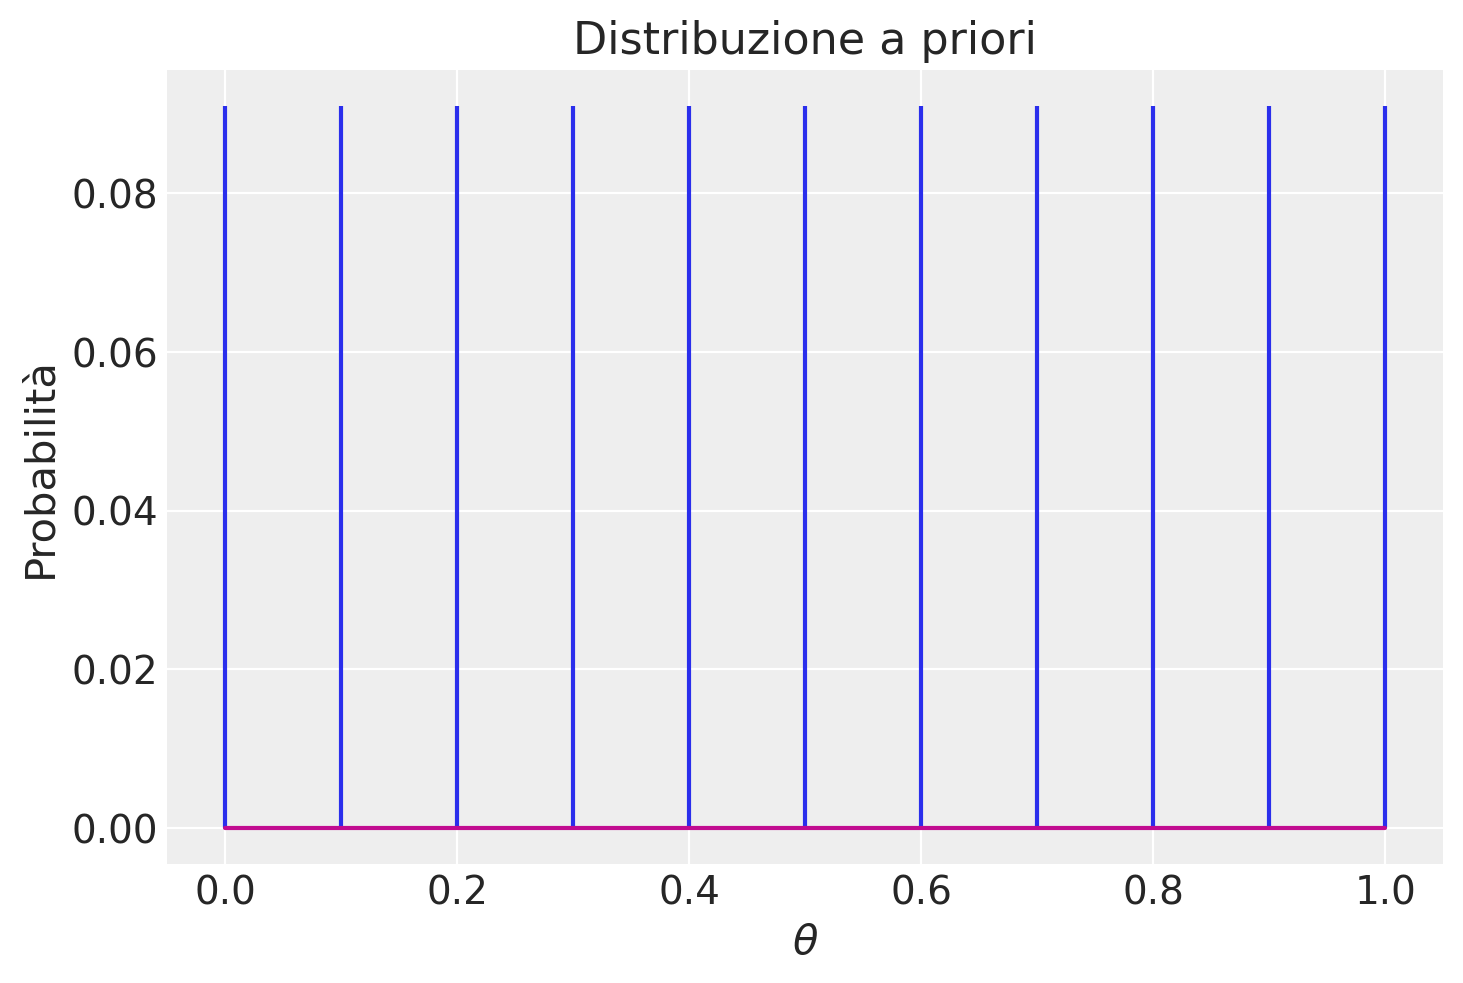

In [6]:
plt.stem(theta, unif_distr_pdf, markerfmt=" ")
plt.title("Distribuzione a priori")
plt.xlabel("$\\theta$")
plt.ylabel("Probabilità");

Se, al contrario, riteniamo che i valori centrali nella distribuzione di $\theta$ siano più credibili rispetto a quelli situati agli estremi, potremmo esprimere questa opinione soggettiva mediante la seguente distribuzione di massa di probabilità.

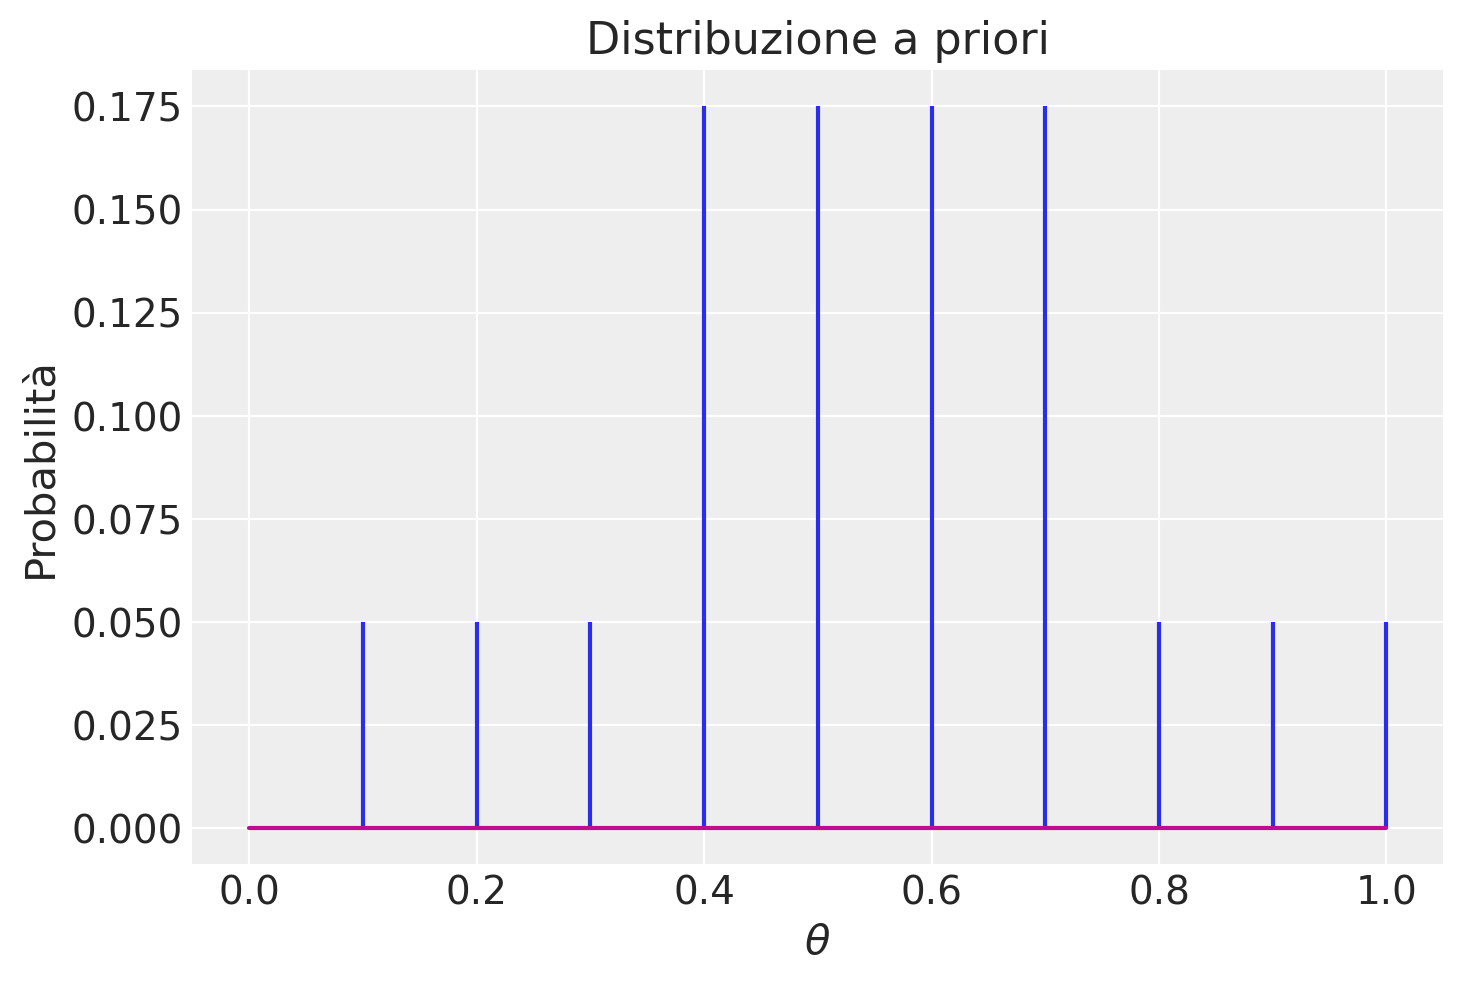

In [7]:
not_unif_distr_pdf = [0, 0.05, 0.05, 0.05, 0.175, 0.175, 0.175, 0.175, 0.05, 0.05, 0.05]
plt.stem(theta, not_unif_distr_pdf, markerfmt=" ")
plt.title("Distribuzione a priori")
plt.xlabel("$\\theta$")
plt.ylabel("Probabilità");

La prima distribuzione di probabilità è una distribuzione discreta uniforme, in quanto assegna la stessa probabilità a ciascun elemento dell'insieme discreto su cui è definita, ossia i valori $\{0, 0.1, 0.2, \dots, 1.0\}$. La seconda distribuzione di probabilità, pur essendo discreta, segue un andamento non uniforme: si presume che $\theta$ abbia una probabilità maggiore di assumere un valore nell'insieme $\{0.4, 0.5, 0.6, 0.7\}$ rispetto all'insieme $\{0.1, 0.2, 0.3, 0.8, 0.9, 1.0\}$.

Le credenze iniziali riguardo ai possibili valori di $\theta$ costituiscono la "distribuzione a priori". L'inferenza bayesiana aggiorna queste credenze iniziali utilizzando le informazioni ottenute dai dati. Queste informazioni vengono combinate con le credenze iniziali su $\theta$ attraverso l'applicazione del teorema di Bayes, allo scopo di ottenere la "distribuzione a posteriori". Quest'ultima rappresenta le nostre credenze aggiornate sui possibili valori di $\theta$ dopo l'osservazione dei dati.

Supponiamo di aver osservato 35 "successi" in 75 prove. Per calcolare la distribuzione a posteriori, utilizzeremo la seconda delle due distribuzioni a priori precedentemente descritte. In base al teorema di Bayes, la distribuzione a posteriori si ottiene moltiplicando la verosimiglianza per la distribuzione a priori e quindi dividendo per una costante di normalizzazione (la verosimiglianza marginale):

$$ p(\theta \mid y) = \frac{p(y \mid \theta)p(\theta)}{p(y)}. $$

Per calcolare la funzione di verosimiglianza, $p(y \mid \theta)$, dobbiamo comprendere il processo mediante il quale i dati sono stati generati. Nel nostro contesto, i dati rappresentano i risultati di 75 ripetizioni di un esperimento casuale che può produrre solo due risultati possibili: "presenza" e "assenza" di ideazione suicidaria. Inoltre, i 75 casi esaminati sono tra loro indipendenti (i pazienti non si influenzano reciprocamente). In tali circostanze, possiamo assumere che il modello generativo dei dati sia il modello binomiale con probabilità sconosciuta $\theta$.

Utilizzando Python, è possibile calcolare la funzione di verosimiglianza tramite la funzione `binom.pmf()`.

In [8]:
lk = stats.binom.pmf(35, 70, theta)
lk = lk / np.sum(lk)
lk

array([0.00000000e+00, 1.99180385e-16, 1.10906788e-07, 1.50811359e-03,
       1.61492440e-01, 6.73998671e-01, 1.61492440e-01, 1.50811359e-03,
       1.10906788e-07, 1.99180385e-16, 0.00000000e+00])

Per i 10 valori $\theta$ considerati, la funzione di verosimiglianza assume la forma indicata dalla figura seguente.

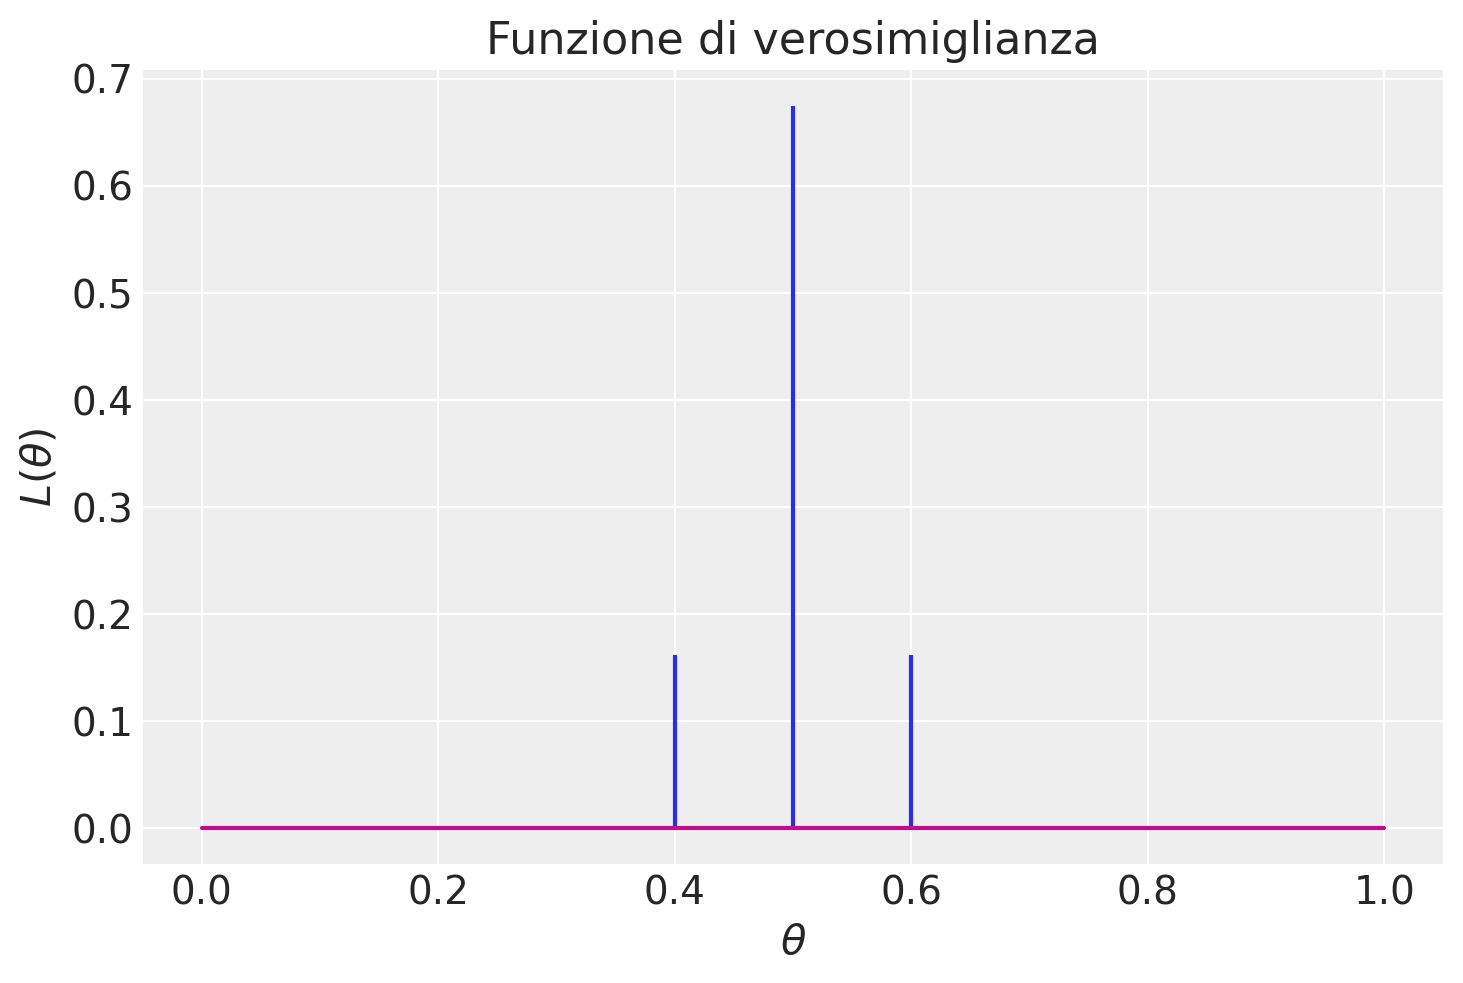

In [9]:
plt.stem(theta, lk, markerfmt=" ")
plt.title("Funzione di verosimiglianza")
plt.xlabel("$\\theta$")
plt.ylabel("$L(\\theta)$");

Per calcolare la distribuzione a posteriori, eseguiamo una moltiplicazione elemento per elemento tra il vettore contenente i valori della distribuzione a priori e il vettore contenente i valori della funzione di verosimiglianza. Usando Python, il risultato si trova nel modo seguente.

In [10]:
not_unif_distr_pdf * lk

array([0.00000000e+00, 9.95901924e-18, 5.54533942e-09, 7.54056793e-05,
       2.82611770e-02, 1.17949767e-01, 2.82611770e-02, 2.63919878e-04,
       5.54533942e-09, 9.95901924e-18, 0.00000000e+00])

Per illustrare con un esempio, il valore dell'ottavo elemento della distribuzione a posteriori si calcola come segue (tenendo presente che in Python gli indici partono da 0):

In [11]:
not_unif_distr_pdf[7] * lk[7]

0.0002639198775144677

Dopo questa moltiplicazione, otteniamo una distribuzione che rappresenta le probabilità condizionate dei possibili valori di $\theta$ alla luce dei dati osservati. Tuttavia, questa distribuzione potrebbe non è normalizzata, il che significa che la somma di tutte le probabilità condizionate non è uguale a 1.

Per ottenere una distribuzione di probabilità correttamente normalizzata, dobbiamo dividere ciascun valore ottenuto precedentemente per la probabilità marginale dei dati $y$. La probabilità marginale dei dati $y$ è una costante di normalizzazione e può essere calcolata utilizzando la legge della probabilità totale (si veda l'eq. {eq}`eq-prob-tot`). 

Per chiarire, ricordiamo che, nel capitolo {ref}`cond-prob-notebook` abbiamo considerato il caso di una partizione dello spazio campione in due eventi mutualmente esclusivi ed esaustivi, $H_1$ e $H_2$. All'interno dello spazio campione abbiamo definito un evento $E$ non nullo e abbiamo visto che $P(E) = P(E \cap H_1) + P(E \cap H_2)$, ovvero $P(E) = P(E \mid H_1) P(H_1) + P(E \mid H_2) P(H_2)$. Usando la terminologia che stiamo usando qui, $P(E \mid H_i)$ corrisponde alla funzione di verosimiglianza e $P(H_i)$ corrisponde alla funzione a priori. Nel caso discreto, come quello che stiamo considerando ora, il teorema della probabilità totale ci dice dunque che dobbiamo fare la somma dei prodotti tra i valori della funzione di verosimiglianza e i corrispondenti valori della distribuzione a priori. 

In [12]:
np.sum(not_unif_distr_pdf * lk)

0.17481145807507814

Otteniamo dunque il seguente risultato.

In [13]:
post = (not_unif_distr_pdf * lk) / np.sum(not_unif_distr_pdf * lk)
print(post)

[0.00000000e+00 5.69700599e-17 3.17218304e-08 4.31354330e-04
 1.61666617e-01 6.74725608e-01 1.61666617e-01 1.50974015e-03
 3.17218304e-08 5.69700599e-17 0.00000000e+00]


Verifichiamo di avere ottenuto una distribuzione di massa di probabilità:

In [14]:
np.sum(post)

1.0000000000000002

Esaminiamo la distribuzione a posteriori di $\theta$ con un grafico.

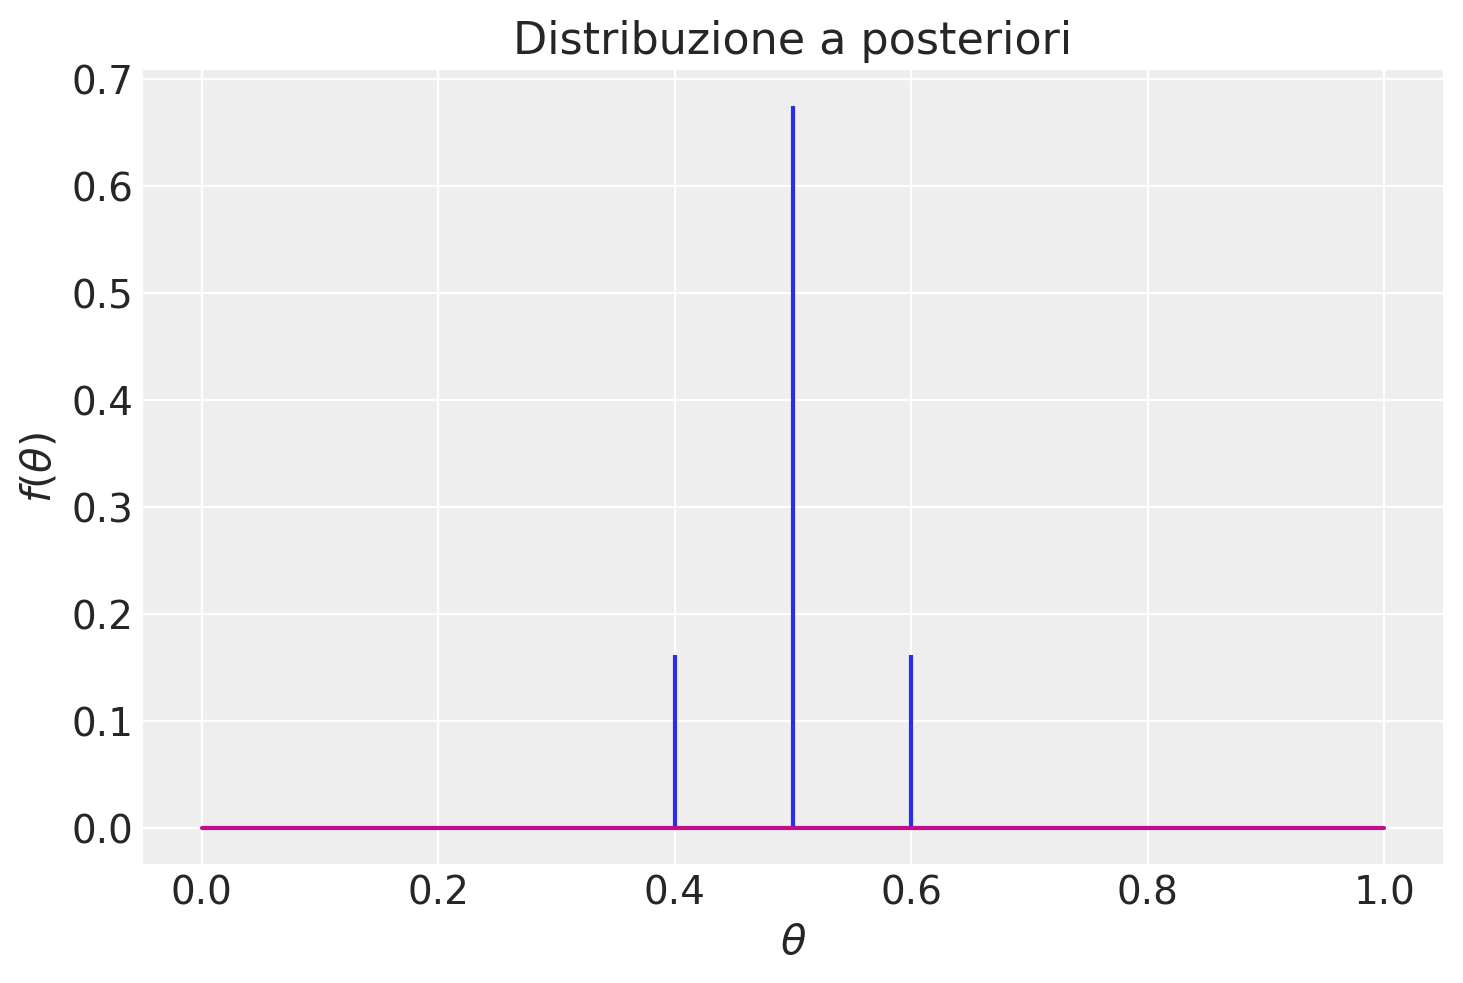

In [15]:
plt.stem(theta, post, markerfmt=" ")
plt.title("Distribuzione a posteriori")
plt.xlabel("$\\theta$")
plt.ylabel(r"$f(\theta)$");

Una volta trovata la distribuzione a posteriori di $\theta$, possiamo calcolare altre quantità di interesse. Ad esempio, la moda a posteriori di $\theta$ può essere individuata direttamente dal grafico precedente e risulta pari a 0.5. Per calcolare invece la media a posteriori, ci avvaliamo della formula del valore atteso delle variabili casuali.

In [16]:
np.sum(theta * post)

0.5002156771647586

La varianza della distribuzione a posteriori è

In [17]:
np.sum(theta**2 * post) - (np.sum(theta * post)) ** 2

0.0033109353091205773

Con questo metodo, possiamo calcolare la distribuzione a posteriori di $\theta$ per qualsiasi distribuzione a priori discreta.

## Aggiornamento bayesiano con una distribuzione a priori continua 

A fini didattici, abbiamo esaminato il caso di una distribuzione a priori discreta. Tuttavia, è importante notare che l'impiego di una distribuzione a priori continua, come la distribuzione Beta, risulta più appropriato in quanto permette di rappresentare un'ampia gamma di possibili valori per il parametro non noto $\theta$, senza essere vincolati a un insieme discreto di valori. Inoltre, la distribuzione Beta presenta l'ulteriore vantaggio di avere un dominio definito nell'intervallo [0, 1], che corrisponde alla gamma dei possibili valori per la proporzione $\theta$.

Per esempio, consideriamo la distribuzione Beta(2, 2), caratterizzata da una simmetria nella sua forma. Per valutare la distribuzione Beta in corrispondenza di punti specifici, come ad esempio 0.5, 0.8 e 1.2, possiamo fare affidamento sulla funzione `beta.pdf`. A titolo illustrativo, la densità di probabilità della distribuzione Beta(2, 2) nel caso del valore 0.5 risulta essere 1.5, suggerendo che i valori di $\theta$ vicini a 0.5 appaiono più plausibili rispetto a quelli intorno a 0.8, dove la funzione assume un valore di 0.96. È importante sottolineare che la densità di probabilità della distribuzione Beta(2, 2) relativa al valore 1.2 è pari a 0, poiché tale valore esula dall'intervallo di definizione della distribuzione (0 e 1). La distribuzione Beta(2, 2) è illustrata nella figura qui di seguito.

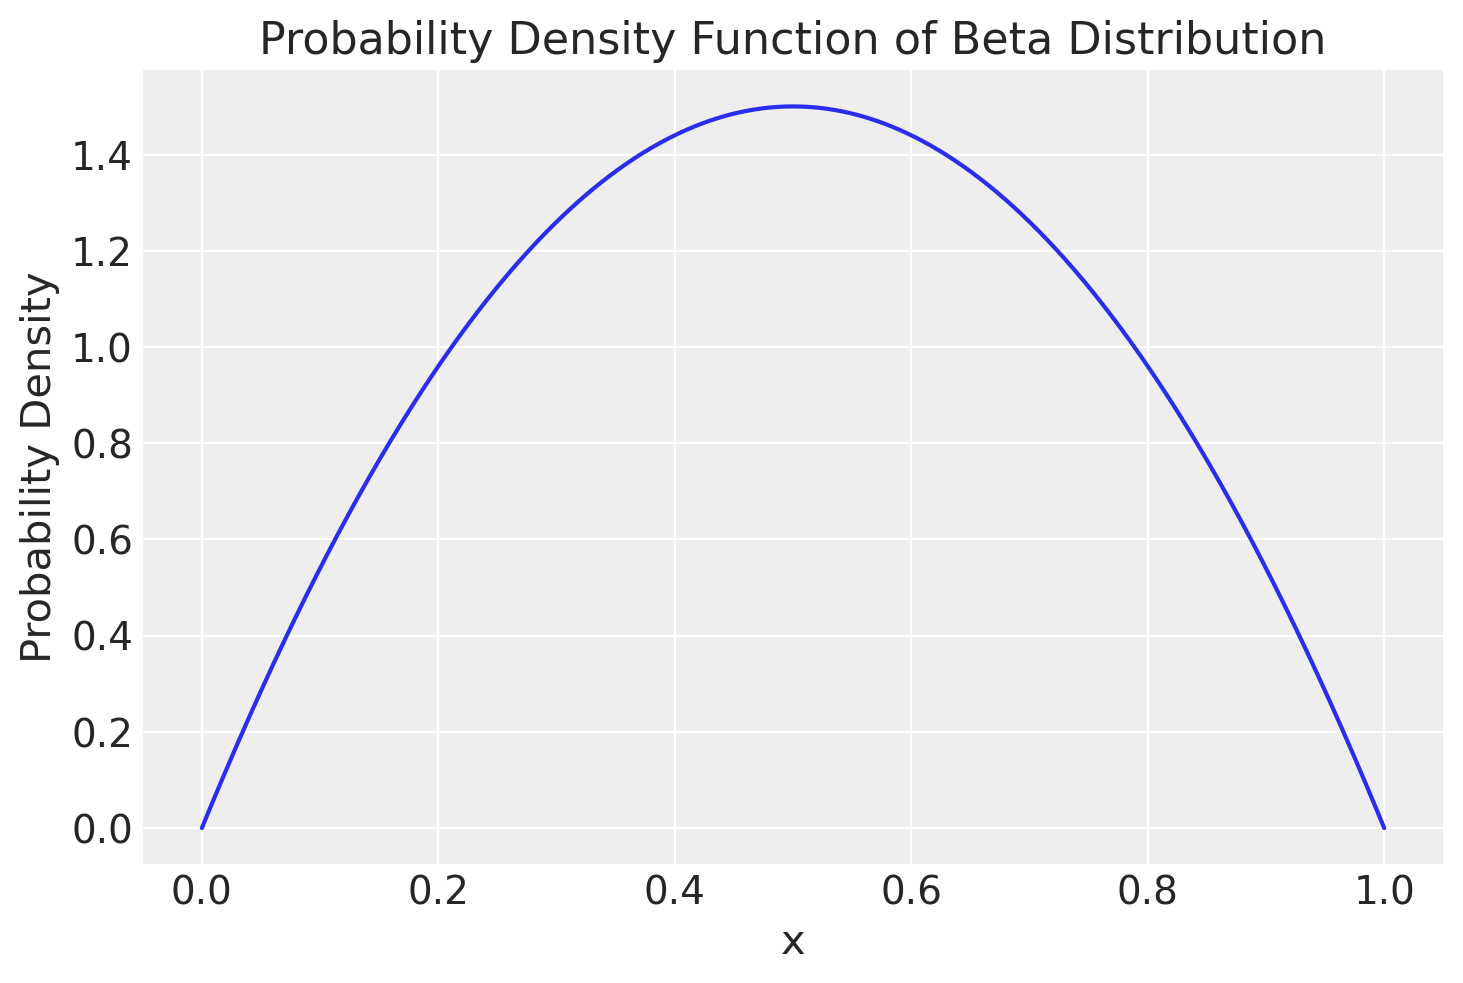

In [18]:
alpha = 2
beta = 2

x = np.linspace(0, 1, 1000)
pdf = stats.beta.pdf(x, alpha, beta)

plt.plot(x, pdf)
plt.xlabel('x')
plt.ylabel('Probability Density')
_ = plt.title('Probability Density Function of Beta Distribution')

Supponiamo -- solo allo scopo di illustrare la procedura -- che le nostre credenze a priori siano rappresentate da una Beta(2, 5).

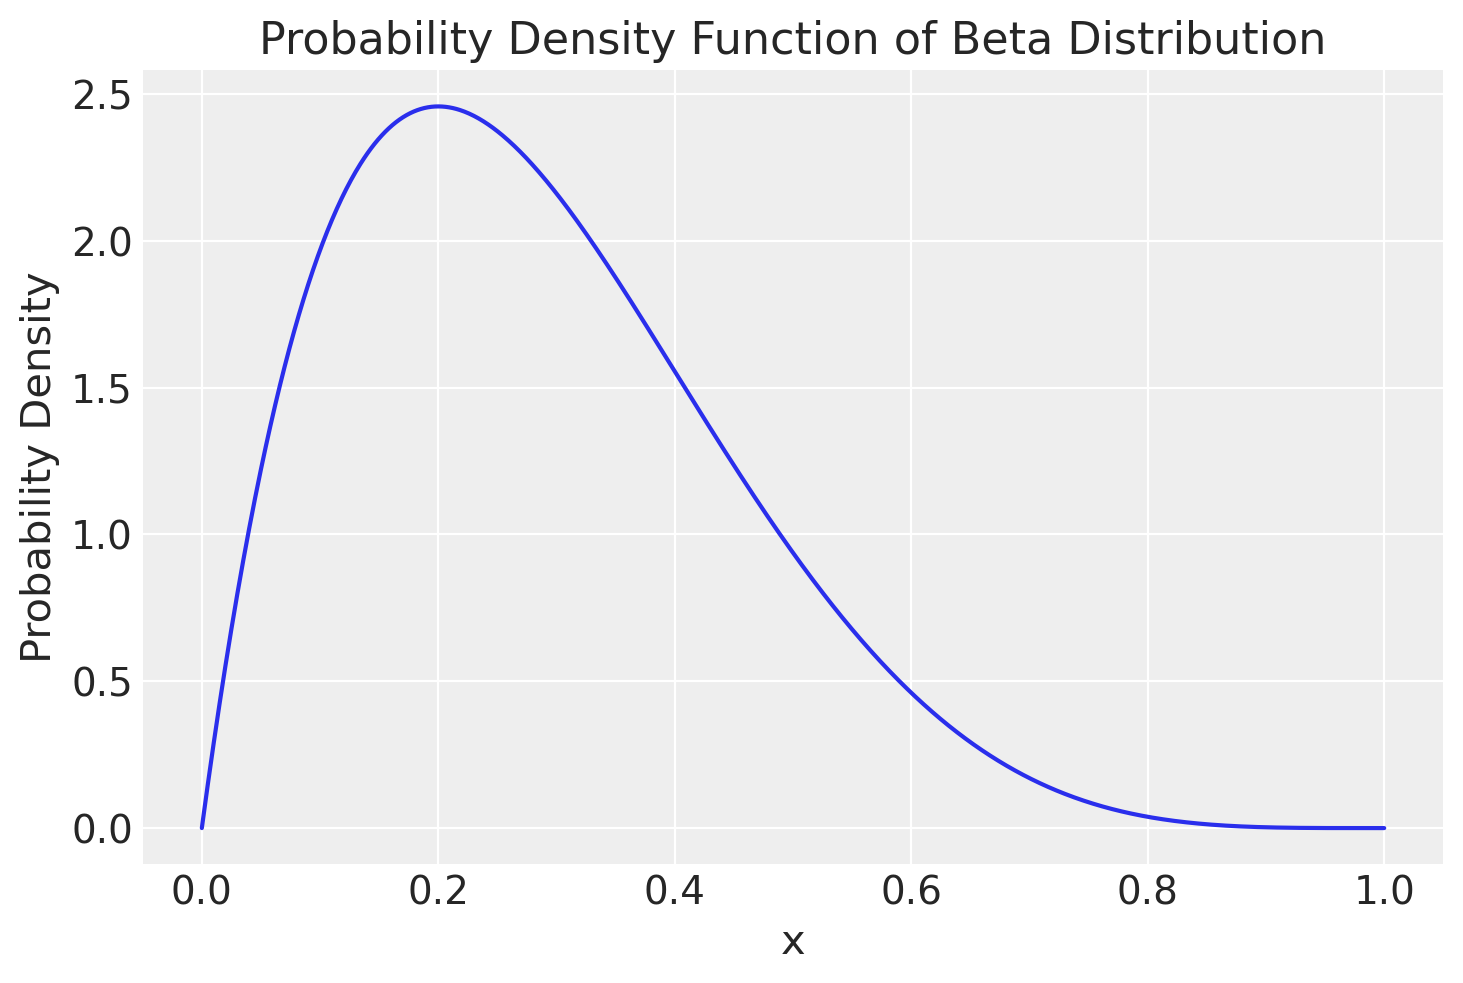

In [19]:
alpha = 2
beta = 5

x = np.linspace(0, 1, 1000)
pdf = stats.beta.pdf(x, alpha, beta)

plt.plot(x, pdf)
plt.xlabel('x')
plt.ylabel('Probability Density')
_ = plt.title('Probability Density Function of Beta Distribution')

Nel seguente esempio, useremo la funzione `beta.pdf()` per generare una distribuzione a priori discretizzata. 

In [20]:
print(stats.beta.pdf(theta, 2, 5))

[0.     1.9683 2.4576 2.1609 1.5552 0.9375 0.4608 0.1701 0.0384 0.0027
 0.    ]


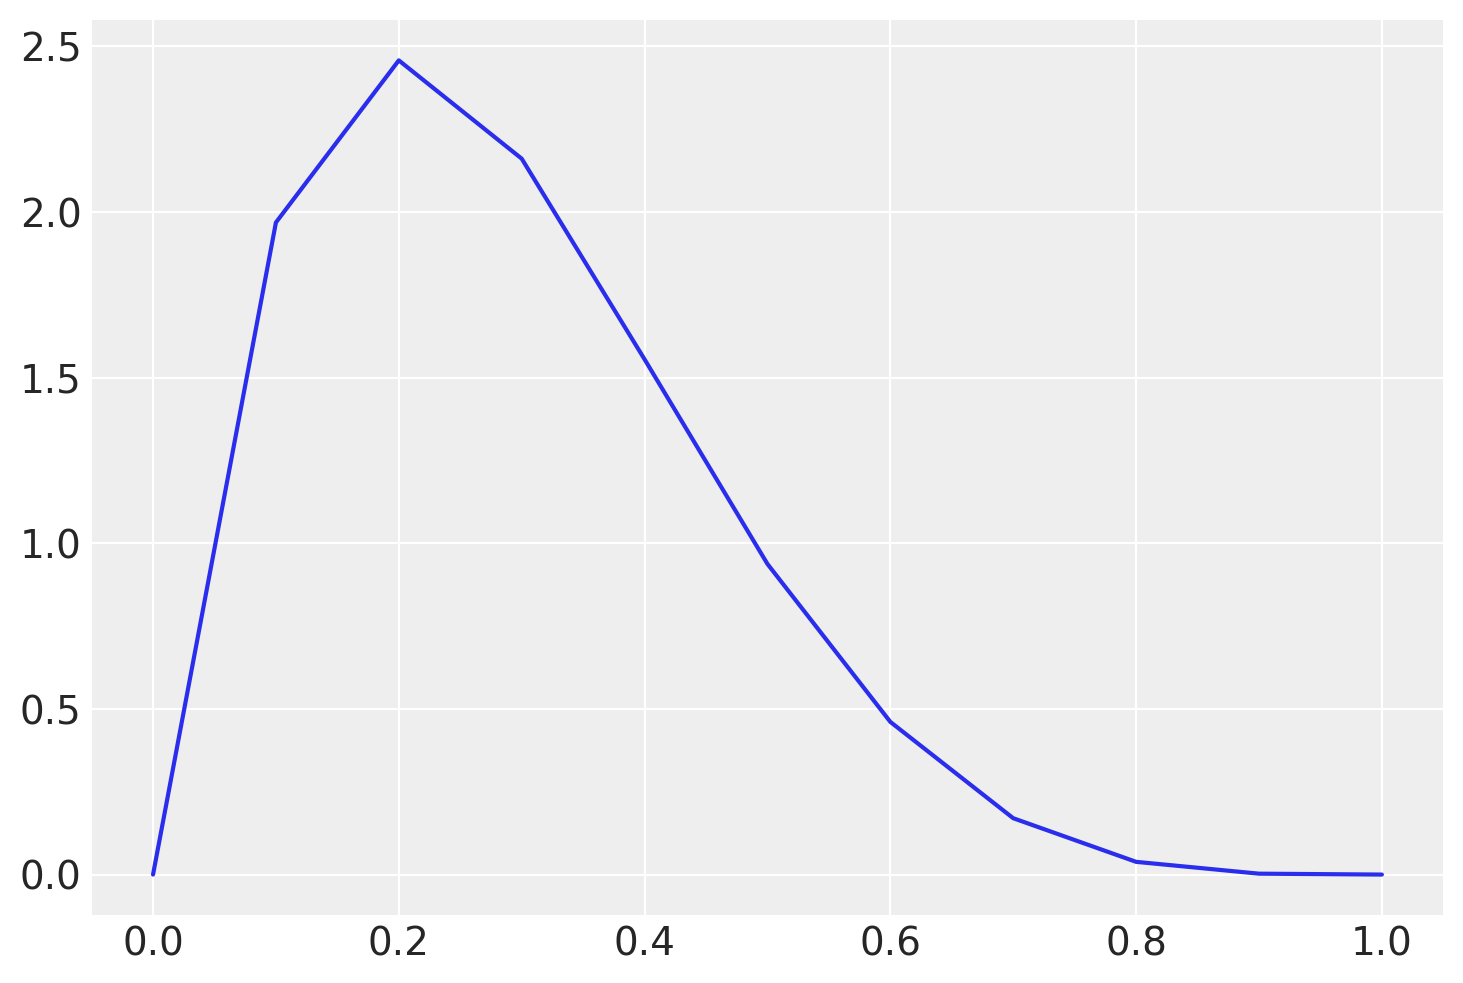

In [21]:
_ = plt.plot(theta, stats.beta.pdf(theta, 2, 5))

Ora però usiamo un numero maggiore di valori $\theta$.

In [22]:
theta = np.linspace(0, 1, 1001)
print(theta)

[0.    0.001 0.002 ... 0.998 0.999 1.   ]


Calcoliamo la distribuzione a priori normalizzata.

In [23]:
prior = stats.beta.pdf(theta, 2, 5) 
prior = prior / np.sum(prior)
print(prior)

[0.00000000e+00 2.98802546e-05 5.95215869e-05 ... 4.79041198e-13
 2.99700749e-14 0.00000000e+00]


In [24]:
sum(prior)

1.0000000000000002

Per calcolare la verosimiglianza, seguiamo la medesima procedura illustrata nel capitolo {ref}`cap-likelihood`. In aggiunta, effettuiamo la normalizzazione dei valori discretizzati della verosimiglianza, come precedentemente descritto.

In [25]:
lk = stats.binom.pmf(6, 9, theta)
lk = lk / np.sum(lk)
print(lk)

[0.00000000e+00 8.37482519e-19 5.34380847e-17 ... 6.63976213e-09
 8.34972583e-10 0.00000000e+00]


Infine, otteniamo la distribuzione a posteriori moltiplicando la distribuzione a priori per la verosimiglianza e dividendo per la costante di normalizzazione.

In [26]:
post = (prior * lk) / np.sum(prior * lk)

In [27]:
np.sum(post)

1.0

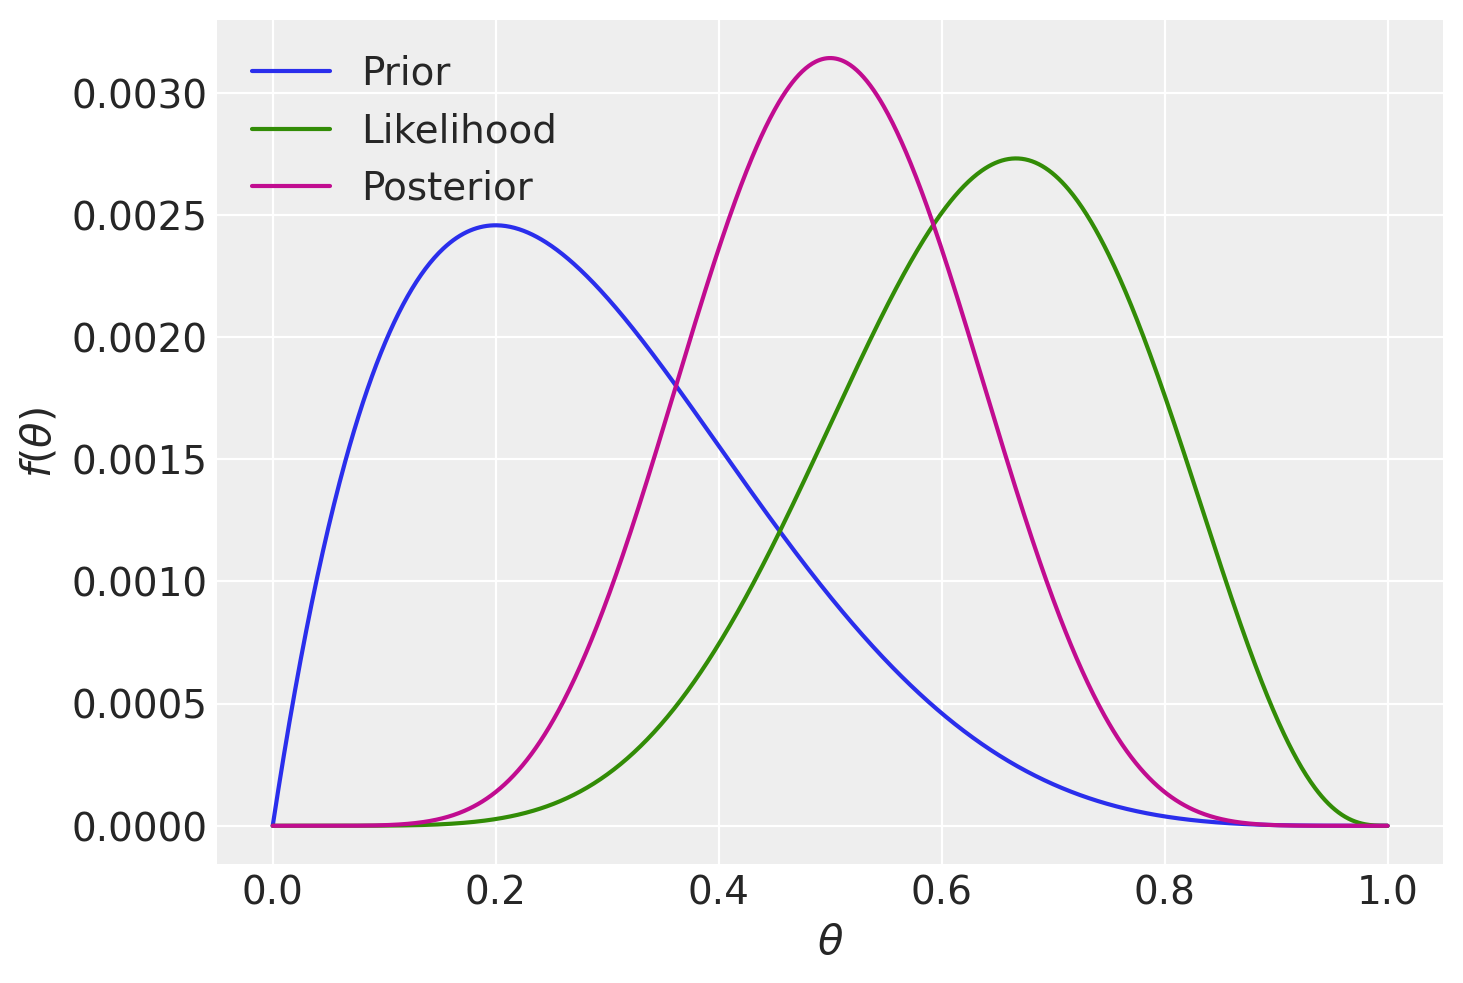

In [28]:
plt.plot(theta, prior, linestyle="solid", color="C0", label="Prior")
plt.plot(theta, lk, linestyle="solid", color="C2", label="Likelihood")
plt.plot(theta, post, linestyle="solid", color="C3", label="Posterior")
plt.xlabel(r"$\theta$")
plt.ylabel(r"$f(\theta)$")
_ = plt.legend()

Possiamo calcolare la media e la deviazione standard della distribuzione a posteriori come abbiamo fatto in precedenza.

In [29]:
# media
np.sum(theta * post)

0.5000000000000001

In [30]:
# deviazione standard
np.sqrt(np.sum(theta**2 * post) - (np.sum(theta * post)) ** 2)

0.12126781251816628

## Sintesi ed elaborazioni inferenziali sulla distribuzione a posteriori

Una volta ottenuta la distribuzione a posteriori, è possibile generare un campione casuale da questa distribuzione. A titolo di esempio, possiamo estrarre un campione di 10000 punti dalla distribuzione a posteriori di $\theta$ che abbiamo calcolato.

In [31]:
samples = np.random.choice(theta, p=post, size=int(1e4), replace=True)

L'istruzione precedente genera un array denominato `samples` contenente 10000 punti campionati dalla distribuzione a posteriori calcolata. La funzione `np.random.choice` viene impiegata per selezionare casualmente i valori `theta` basandosi sulle probabilità definite da `post`.

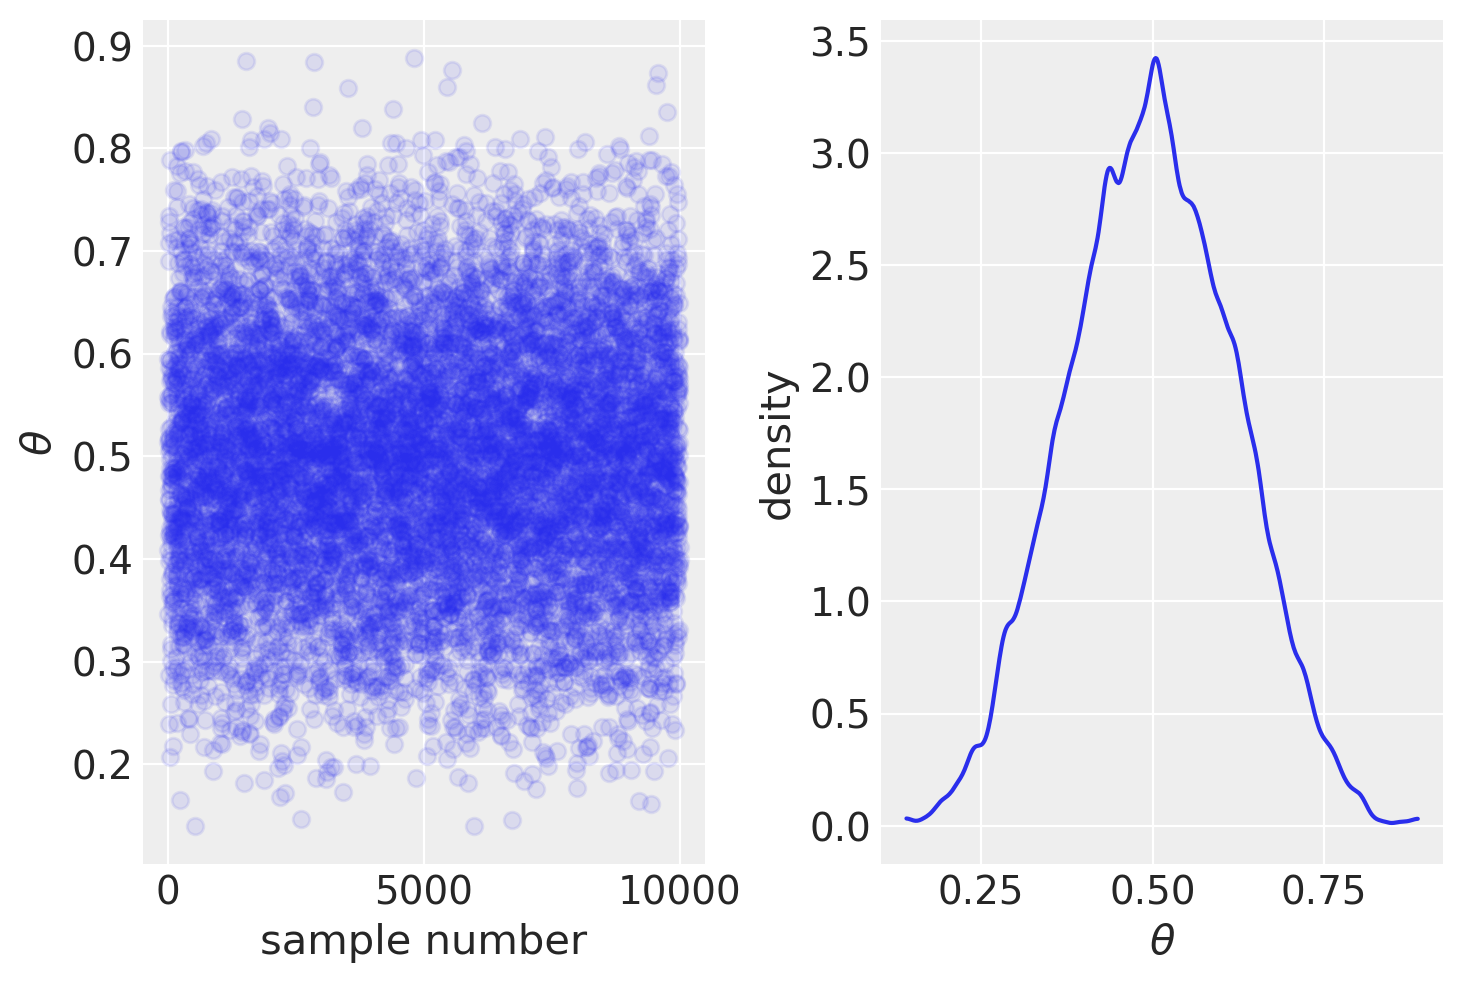

In [32]:
# First subplot: Scatter plot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(samples, 'o', alpha=0.1)
plt.xlabel("sample number")
plt.ylabel(r"$\theta$")

# Second subplot: KDE plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
az.plot_kde(samples)
plt.xlabel(r"$\theta$")
_ = plt.ylabel("density")

Sfruttando il campione estratto dalla distribuzione a posteriori, è possibile calcolare diverse quantità di interesse. Ad esempio, la stima della media a posteriori di $\theta$ si ottiene semplicemente calcolando la media dei valori così ottenuti.

In [33]:
np.mean(samples)

0.499356

In maniera analoga possiamo calcolare la deviazione standard della distribuzione a posteriori di $\theta$.

In [34]:
np.std(samples)

0.1199298022344738

La moda a posteriori si può calcolare nel modo seguente.

In [35]:
print(theta[post == max(post)])

[0.5]


Oppure, usando il campione estratto dalla distribuzione a posteriori di $\theta$, otteniamo

In [36]:
stats.mode(samples)[0]

0.507

Usando il campione estratto dalla distribuzione a posteriori, è immediato trovare la mediana a posteriori di $\theta$.

In [37]:
np.median(samples)

0.5

Possiamo calcolare la probabilità di varie ipotesi relative a $\theta$ nella distribuzione a posteriori. Per esempio, calcoliamo la probabilità $P(\theta < 0.5)$. 

In [38]:
sum(post[theta < 0.5])

0.49842895507812507

Alternativamente, utilizzando il campione estratto dalla distribuzione a posteriori di $\theta$, otteniamo un risultato analogo, sebbene soggetto a variazioni dovute all'approssimazione numerica.

In [39]:
sum(samples < 0.5) / 1e4

0.4996

Possiamo trovare la probabilità a posteriori che $\theta$ sia compresa in un dato intervallo. Per esempio, troviamo $P(0.5 < \theta < 0.75)$.

In [40]:
sum((samples > 0.6) & (samples < 0.8)) / 1e4

0.2073

Utilizzando il campionamento effettuato dalla distribuzione a posteriori di $\theta$, è possibile risolvere il problema inverso, ovvero determinare l'intervallo che contiene $\theta$ con una specifica probabilità. Ad esempio, si può calcolare l'intervallo che ha una probabilità pari a 0.94 di contenere $\theta$, basandosi sulla distribuzione a posteriori campionata.

In [41]:
np.percentile(samples, [2, 98])

array([0.261, 0.741])

L'intervallo specificato è noto come *intervallo di credibilità* e rappresenta una quantificazione statistica dell'incertezza associata alla stima del parametro $\theta$. In termini probabilistici, si può affermare con il 94% di credibilità che il valore "vero" di $\theta$ è contenuto nell'intervallo [0.26, 0.74].

Se vogliamo trovare l'intervallo di credibilità a più alta densità a posteriori (HPD), usiamo la funzione ArviZ `hdi()` (si veda il capitolo {ref}`sintesi-distr-post-notebook`).

In [42]:
az.hdi(samples, hdi_prob=0.94)

array([0.278, 0.721])

Nel contesto attuale, la distribuzione a posteriori è simmetrica. Di conseguenza, l'intervallo di credibilità calcolato attraverso i quantili e l'intervallo di credibilità a più alta densità a posteriori (HPDI) sono molto simili.

## Qual è il modo migliore per stimare il parametro $\theta$?

Nonostante abbiamo discusso in precedenza dei diversi metodi di stima puntuale e intervallare per riassumere la distribuzione a posteriori di $\theta$, la migliore stima del parametro che stiamo cercando di inferire è rappresentata dall'intera distribuzione a posteriori. Per citare le parole di  @McElreath_rethinking:

> That an arbitrary interval contains an arbitrary value is not meaningful. Use the whole distribution.

## Metodo basato su griglia

Il metodo utilizzato in questo capitolo per generare la distribuzione a posteriori è noto come metodo basato su griglia. Questo metodo numerico esatto si basa sul calcolo della distribuzione a posteriori mediante una griglia di punti uniformemente spaziati. Nonostante la maggior parte dei parametri sia continua, l'approssimazione della distribuzione a posteriori può essere ottenuta considerando soltanto una griglia finita di valori dei parametri. Il metodo segue quattro fasi:

1. Fissare una griglia discreta di possibili valori dei parametri.
2. Valutare la distribuzione a priori e la funzione di verosimiglianza per ciascun valore della griglia.
3. Calcolare l'approssimazione della densità a posteriori, ottenuta moltiplicando la distribuzione a priori per la funzione di verosimiglianza per ciascun valore della griglia e normalizzando i prodotti in modo che la loro somma sia uguale a 1.
4. Selezionare $n$ valori casuali dalla griglia per ottenere un campione casuale della densità a posteriori normalizzata.

Questo metodo può essere potenziato aumentando il numero di punti nella griglia, ma il limite principale risiede nel fatto che all'aumentare della dimensionalità dello spazio dei parametri, il numero di punti necessari per una stima accurata cresce in modo esponenziale, rendendo il metodo impraticabile per problemi complessi.

In sintesi, l'approccio basato sulla griglia è intuitivo e non richiede competenze di programmazione avanzate per l'implementazione. Inoltre, fornisce un risultato che può essere considerato, per tutti gli scopi pratici, come un campione casuale estratto dalla distribuzione di probabilità a posteriori condizionata ai dati. Tuttavia, questo metodo è limitato a causa della *maledizione della dimensionalità*[^036_posterior_sim-1], il che significa che può essere applicato soltanto a modelli statistici semplici con non più di due parametri. Di conseguenza, in pratica, è spesso sostituito da altre tecniche più efficienti, poiché i modelli impiegati in psicologia richiedono frequentemente la stima di centinaia o anche migliaia di parametri.

[^036_posterior_sim-1]: Per comprendere la maledizione della dimensionalità, possiamo considerare l'esempio di una griglia di 100 punti equispaziati. Nel caso di un solo parametro, sarebbe necessario calcolare solo 100 valori. Tuttavia, se abbiamo due parametri, il numero di valori da calcolare diventa $100^2$. Se invece abbiamo 10 parametri, il numero di valori da calcolare sarebbe di $10^{10}$. È evidente che la quantità di calcoli richiesta diventa troppo grande persino per un computer molto potente. Pertanto, per modelli che richiedono la stima di un numero significativo di parametri, è necessario utilizzare un approccio diverso.

## Commenti e Considerazioni Finali

In questo capitolo, abbiamo esplorato l'aggiornamento bayesiano utilizzando una distribuzione a priori discreta, accennando brevemente al caso delle distribuzioni a priori continue. Quando si affrontano scenari con distribuzioni a priori continue, l'elaborazione della distribuzione a posteriori generalmente richiede la risoluzione di un integrale che, nella maggior parte dei casi, non ammette una soluzione analitica. Tuttavia, ci sono eccezioni notevoli, come nell'inferenza relativa alle proporzioni, dove la distribuzione a priori è modellata come una distribuzione Beta e la funzione di verosimiglianza segue una distribuzione binomiale. In queste circostanze particolari, è possibile derivare analiticamente la distribuzione a posteriori. L'analisi dettagliata di questo caso sarà trattata nel capitolo successivo.

L'aspetto fondamentale della discussione presente risiede nell'approccio adottato per affrontare una specifica questione di ricerca, ossia la quantificazione dell'incertezza relativa alla proporzione di presenza di ideazione suicidaria nella popolazione considerata. Abbiamo illustrato come sia possibile mettere in pratica alcuni dei passaggi del flusso di lavoro bayesiano proposto da @McElreath_rethinking.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [43]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Wed Jul 17 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

pandas    : 2.2.2
scipy     : 1.14.0
seaborn   : 0.13.2
arviz     : 0.18.0
matplotlib: 3.9.1
numpy     : 1.26.4

Watermark: 2.4.3

